In [ ]:

import bbci_lda

In [ ]:
import sklearn.base
sklearn.__version__
sklearn.linear_model._base.LinearClassifierMixin

In [ ]:
%matplotlib qt

# Short ERP Analysis from OpenVibe data converted to gdf
Data was converted to gdf using openvibe-convert.cmd
- First step is to rename and filter the annotations from openvibe
- translate the annotations into markers
- create epochs
- process epochs
- plot ERP
- (?) a bit of statistics

In [348]:
import matplotlib
import numpy as np
#%matplotlib ipympl
import os
import mne
import itertools

In [349]:
# remove me
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf, read_raw_brainvision
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test
from mne.viz.utils import center_cmap

In [350]:

apply_infinite_reference = False
apply_CSD = False  # use Current Source Density (spatial filter)
apply_ASR = True  # use Artifact Subspace Reconstruction (artifact removal)
drop_bad_epochs = False

In [351]:
data_dir=r"C:\BCI\dev\p300_analysis_from_openvibe"
os.path.exists(data_dir)
fnames = []
for file in os.listdir(data_dir):
    if file.endswith(".gdf"):
        fnames.append(os.path.join(data_dir, file))
        print(os.path.join(data_dir, file))

C:\BCI\dev\p300_analysis_from_openvibe\loic12ch-10seq.gdf


### Load gdf files

In [352]:
# load and preprocess data ####################################################
raws = [mne.io.read_raw_gdf(f, preload=True) for f in [fnames[0]]]
#raw = concatenate_raws(raws)
raw = raws[0]

Extracting EDF parameters from C:\BCI\dev\p300_analysis_from_openvibe\loic12ch-10seq.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 84383  =      0.000 ...   164.811 secs...


<ipython-input-352-d0f71234aaee>:2: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raws = [mne.io.read_raw_gdf(f, preload=True) for f in [fnames[0]]]


In [353]:
raw.info['ch_names']

['Channel 1',
 'Channel 2',
 'Channel 3',
 'Channel 4',
 'Channel 5',
 'Channel 6',
 'Channel 7',
 'Channel 8',
 'Channel 9',
 'Channel 10',
 'Channel 11',
 'Channel 12']

### Todo: rereference

In [354]:
nb_chan = len(raw.info['ch_names'])
# define channel names
if nb_chan==12:
    cname = ['Fz', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'P3', 'Pz', 'PO8', 'Oz']
else:
    cname = ['Fz', 'Cz', 'P3', 'Pz', 'P4', 'PO7', 'PO8', 'Oz']
    
nb_def_ch = len(cname)


if nb_chan>8:
    cname.extend(["ch{}".format(i) for i in range(nb_def_ch+1,nb_chan+1)])
print(cname)
cname_map = dict(zip(raw.info['ch_names'], cname))
# define channel types
types = list(itertools.repeat('eeg', nb_def_ch))
if len(raw.info['ch_names'])>nb_def_ch:
    types.extend(list(itertools.repeat('misc', nb_def_ch)))
type_map = dict(zip(cname, types))

# rename and pick eeg
raw.rename_channels(cname_map, allow_duplicates=False)
raw.set_channel_types(type_map)
raw.pick_types(eeg=True, misc=False)


['Fz', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'P3', 'Pz', 'P4', 'Oz', 'ch11', 'ch12']


<RawGDF | loic12ch-10seq.gdf, 10 x 84384 (164.8 s), ~6.5 MB, data loaded>

Set the 10-05 montage defining electrode positions. This will allow topoplots and CSD processing to be made

In [355]:
montage = mne.channels.make_standard_montage('standard_1005')
raw = raw.set_montage(montage, match_case=False) 

In [356]:
### Calculate an infinite reference

Extract 50Hz power to detect disconnected electrodes

In [357]:
psd, freqs = mne.time_frequency.psd_welch(raw,verbose=True)
power_50hz = psd[:,np.where(freqs ==60)]
mne.preprocessing.bads._find_outliers(power_50hz.squeeze(), threshold=3, max_iter=5, tail=0)

Effective window size : 0.500 (s)


array([], dtype=int64)

Detect outliers based on channel variance

In [358]:
ch_var  = [np.var(raw._data[i,:]) for i in list(range(raw._data.shape[0]))]
mne.preprocessing.bads._find_outliers(ch_var, threshold=3, max_iter=5, tail=0)

array([], dtype=int64)

In [359]:
ch_var

[1.0907115126437862e-06,
 2.203562375926038e-06,
 4.469034596181456e-06,
 2.5300095307354156e-06,
 3.3386334493362235e-09,
 2.52940765581963e-06,
 4.029803267587387e-06,
 2.5294906838808692e-06,
 1.024913970458585e-09,
 1.7756592963980943e-07]

In [360]:
if apply_infinite_reference:
    raw.del_proj()  # remove our average reference projector first
    sphere = mne.make_sphere_model('auto', 'auto', raw.info)
    src = mne.setup_volume_source_space(sphere=sphere, exclude=30., pos=15.)
    forward = mne.make_forward_solution(raw.info, trans=None, src=src, bem=sphere)
    raw_rest = raw.copy().set_eeg_reference('REST', forward=forward)

    for title, _raw in zip(['Original', 'REST (∞)'], [raw, raw_rest]):
        fig = _raw.plot(n_channels=len(raw), scalings=dict(eeg=5e-5))
        # make room for title
        fig.subplots_adjust(top=0.9)
        fig.suptitle('{} reference'.format(title), size='xx-large', weight='bold')

## Bandpass the signal
Removes noise and drift from the EEG signal by applying a infinite impulse response (two-pass) filter between .5 and 40Hz

In [361]:
raw.filter(.5, 40, fir_window='hann', method='iir')
raw.notch_filter(50)  # removes 50Hz noise

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 40.00 Hz: -6.02, -6.02 dB

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3381 samples (6.604 sec)



<RawGDF | loic12ch-10seq.gdf, 10 x 84384 (164.8 s), ~6.5 MB, data loaded>

Plot the filtered signal

In [362]:
raw.plot()
apply_CSD

False

In [363]:
mne.__version__

'0.23.0'

In [416]:
#Apply a variance based channel rejection if artifacts are present >30% of the time
def detec_rej_channel(raw, duration=.2, overlap_duration=.1, threshold_eeg=100e-6, reject_ratio=.3):

    epochs_rej = mne.make_fixed_length_epochs(raw,duration=duration, overlap=overlap_duration, preload=True)
    epochs_rej._data.shape
    diff = np.max(epochs_rej._data, axis=2) - np.min(epochs_rej._data, axis=2)

    print(diff.shape)

    rej = (diff>=threshold_eeg).astype(np.float64)
    sns.heatmap(rej)


    # calculate ratio of rejected trials
    ratios = np.sum(rej,axis=0) / rej.shape[0]
    
    ret = np.argwhere(ratios >= reject_ratio).tolist()[0]
    if len(ret)>0:
        print('Found {} channels with at least {}% {}s epochs > {} amplitude)'.format(len(ret), 
                                                                                              reject_ratio*100, duration,
                                                                                      threshold_eeg))
    return ret
    
rej_ch = detec_rej_channel(raw)


Not setting metadata
Not setting metadata
1647 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1647 events and 102 original time points ...
0 bad epochs dropped
(1647, 10)
Found 1 channels with at least 30.0% 0.2s epochs > 0.0001 amplitude)


In [422]:
new_bads = [raw.info['ch_names'][ch] for ch in rej_ch]
raw.info['bads'].extend(new_bads)
raw.pick_types(eeg=True)

<RawGDF | loic12ch-10seq.gdf, 9 x 84384 (164.8 s), ~5.8 MB, data loaded>

## Artifact Subspace Reconstruction fitting and reconstruction

In [423]:
if apply_ASR:
    #!pip install meegkit pymanopt
    from meegkit.asr import ASR
    fs = int(raw.info["sfreq"])  # sampling frequency
    method='riemann'  # if error, use 'euclid' -> actually the case
    window_s=.5  # .5 sec window of analysis
    data_interval_s  = None # (begin, end) in sec of the training sample
    estimator='lwf'  #leave blank if using euclidian mode 

    # define the ASR model using riemannian method
    #asr_model = ASR(sfreq=fs, method=method, win_len=window_s, estimator=estimator)

    # if failing (after trying twice. SVD error occurs for no reason sometimes)
    asr_model = ASR(sfreq=fs, method="euclid", win_len=window_s)

    # The best would be to choose another recording during the same session to train the model without overfitting
    data = raw._data  # the numpy array with data is stored in the _data variable

    # Select a time interval for training data
    train_idx = None
    if data_interval_s is not None:
        train_idx = np.arange(data_interval_s[0] * fs, data_interval_s[1] * fs, dtype=int)
    # otherwise select the whole training set
    else:
        train_idx = np.arange(0, data.shape[1])

    train_data = data[:, train_idx]
    print('Training on samples of size {}'.format(train_data.shape))

    # fir the ASR model with data intervals
    _, sample_mask = asr_model.fit(train_data)
    print('Model trained')


Training on samples of size (9, 84384)
Model trained


### Clean the current dataset
Please check whether using this artifact filtering method increases signal to noise ratio rather than reducing it

In [424]:
if apply_ASR:
    clean =  asr_model.transform(raw._data)

    display_asr_results = True
    display_window_s = 15  # 

    if display_asr_results:  #
        data_p = raw._data[0:fs*display_window_s]  # reshape to (n_chans, n_times)
        clean_p = clean[0:fs*display_window_s]

        ###############################################################################
        # Plot the results
        # -----------------------------------------------------------------------------
        #
        # Data was trained on a 40s window from 5s to 45s onwards (gray filled area).
        # The algorithm then removes portions of this data with high amplitude
        # artifacts before running the calibration (hatched area = good).
        nb_ch_disp = 5
        times = np.arange(data_p.shape[-1]) / fs
        f, ax = plt.subplots(nb_ch_disp, sharex=True, figsize=(32, 16))
        for i in range(nb_ch_disp):
            # ax[i].fill_between(train_idx / fs, 0, 1, color='grey', alpha=.3,
            #                   transform=ax[i].get_xaxis_transform(),
            #                   label='calibration window')
            # ax[i].fill_between(train_idx / fs, 0, 1, where=sample_mask.flat,
            #                   transform=ax[i].get_xaxis_transform(),
            #                   facecolor='none', hatch='...', edgecolor='k',
            #                   label='selected window')
            ax[i].plot(times, data_p[i], lw=.5, label='before ASR')
            ax[i].plot(times, clean_p[i], label='after ASR', lw=.5)
            # ax[i].plot(times, raw[i]-clean[i], label='Diff', lw=.5)
            # ax[i].set_ylim([-50, 50])
            ax[i].set_ylabel(f'ch{i}')
            ax[i].set_yticks([])
        ax[i].set_xlabel('Time (s)')
        ax[0].legend(fontsize='small', bbox_to_anchor=(1.04, 1), borderaxespad=0)
        plt.subplots_adjust(hspace=0, right=0.75)
        plt.suptitle('Before/after ASR')
        plt.show()
    raw.data_ = clean

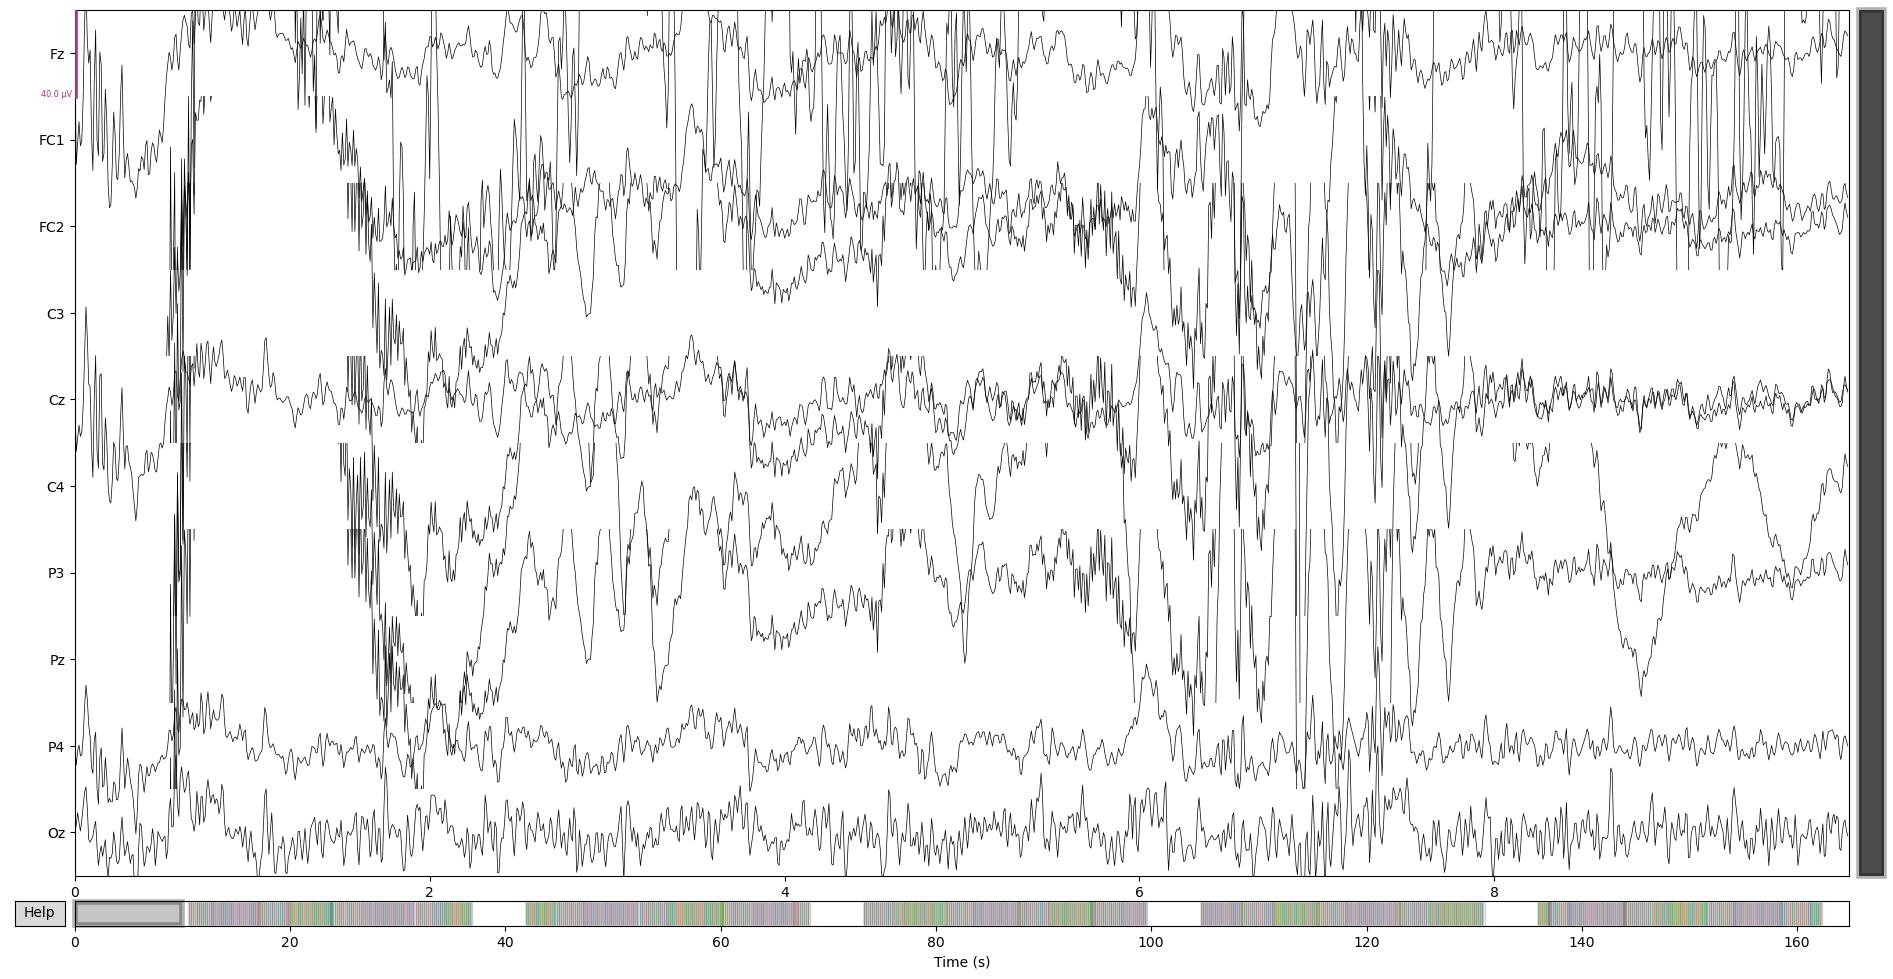

Channels marked as bad: none


In [252]:
raw.plot()

## Apply current source density

In [425]:
if apply_CSD:
    raw_csd = mne.preprocessing.compute_current_source_density(raw)
    raw = raw_csd
    raw_csd.plot()


Dont forget to use the cleaned data

### Convert text annotations (i.e. unprocessed events) into events

Lets have a look at the annotations

In [426]:
import pprint
print(raw.annotations.to_data_frame())
df = raw.annotations.to_data_frame()
print('Displaying all annotations')
annot_codes = [np.int64(n) for n in np.unique(df['description'])]
df['description'] = df['description'].astype(int)


                          onset  duration description
0    1970-01-01 00:00:10.570312  0.001953           1
1    1970-01-01 00:00:10.576172  0.001953       32773
2    1970-01-01 00:00:10.576172  0.001953       33032
3    1970-01-01 00:00:10.576172  0.001953       33285
4    1970-01-01 00:00:10.630859  0.001953       32779
...                         ...       ...         ...
2805 1970-01-01 00:02:42.123047  0.001953       32780
2806 1970-01-01 00:02:42.123047  0.001953       33025
2807 1970-01-01 00:02:42.125000  0.001953       33286
2808 1970-01-01 00:02:42.185547  0.001953       32779
2809 1970-01-01 00:02:42.318359  0.001953       32780

[2810 rows x 3 columns]
Displaying all annotations


In [427]:
#pd.set_option('display.max_rows', None)
#a = df[df['description'] != 33286]
#print(a)
#pd.set_option('display.max_rows', 32)

These annotations seem to relate to hex codes. OpenViBE definitions can be found on [OpenViBE's website](http://openvibe.inria.fr/stimulation-codes/). Let's parse the copypasted list

In [428]:
10.630859-10.576172

0.054686999999999486

In [429]:
import re
tr_sim= ''
pat_extract= re.compile('^([^ ]+)[ ]+0x[0-9A-Fa-f]+[ \/]+([0-9]+)')
#OVTK_GDF_125_Watt                                     0x585       //  1413
k_stim = []
k_stim_int = []
v_stim = []

# read and convert annotations
with open(r'.\ov_stims.txt', 'r') as fd:
    for line in fd.readlines():
        m = pat_extract.match(line)
        v, k = m.groups()
        k_stim.append(k)
        k_stim_int.append(int(k))
        v_stim.append(v)

# format dict and list
stim_map = dict(zip(k_stim_int, v_stim))
stim_map_inv = dict(zip(v_stim, k_stim))

stim_tup = list(zip(k_stim_int, v_stim))

Make a dataframe of the stimuli in common between both

In [430]:
import pandas as pd
df = pd.DataFrame.from_dict(stim_tup)
df.columns = ['coden', 'desc']
df[[c in annot_codes for c in df.coden]]

,coden,desc
125,33025,OVTK_StimulationId_Label_01
126,33026,OVTK_StimulationId_Label_02
127,33027,OVTK_StimulationId_Label_03
128,33028,OVTK_StimulationId_Label_04
129,33029,OVTK_StimulationId_Label_05
130,33030,OVTK_StimulationId_Label_06
131,33031,OVTK_StimulationId_Label_07
132,33032,OVTK_StimulationId_Label_08
133,33033,OVTK_StimulationId_Label_09
134,33034,OVTK_StimulationId_Label_0A


From this table, lets locate and save the codes for Target and Non-Target and give them the following values: target=1 and non-target=0 

In [431]:
target_map = {'33286':0, '33285':1}

Then we can convert annotations into events

In [432]:
events, _ = mne.events_from_annotations(raw, event_id=target_map)
print("Found {} events".format(len(events[:])))

Used Annotations descriptions: ['33285', '33286']
Found 700 events


### Choose the channels to analyze

In [433]:
raw_backup = raw.copy()

In [434]:
# pick all channels
picks = mne.pick_channels(raw.info["ch_names"], include=[])
picks
raw.plot_sensors(show_names=True)
fig = raw.plot_sensors('3d')

### Create epochs for each class

Check for duplicates

In [435]:
from collections import Counter
events[:, 0]
a = np.array(events[:, 0])
dups = [item for item, count in Counter(a).items() if count > 1]
if dups:
    print("WARNING: Duplicate found at sample(s) {}".format(dups))

**Important: disable baseline correction for the analysis!!!**

In [436]:
event_ids = dict(NonTarget=0, Target=1) 
isi = .0625
flash = .125
epoch_length = .800

# In openvibe the next stimulus is announced 1 ISI before presentation, we must account this in the epoching
epochs = mne.Epochs(raw, events, baseline=(isi-.2, isi), event_id=event_ids, tmin=isi-.2, tmax=isi+epoch_length, event_repeated='drop', picks = ['eeg'],
                    preload=True, decim=4)
# To account for the extra isi before stimulus onset we 
epochs.shift_time(-isi, relative=True)
fig = epochs.plot()

Not setting metadata
Not setting metadata
700 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 700 events and 513 original time points ...
0 bad epochs dropped


Making a cross correlation prlot between the electrodes

In [437]:
m = np.corrcoef(raw._data)
hm = sns.heatmap(m,linewidths=0,cmap="YlGnBu").set(title='Cross correlation')


In [438]:
# Detecting channels with very high or very low variance


In [439]:
import scipy
noise_cov = mne.compute_raw_covariance(raw)
noise_cov.plot(raw.info, proj=True)
#noise_cov_baseline.plot(raw.info)
#scipy.signal.correlate2d(raw._data,raw._data)

Using up to 824 segments
Number of samples used : 84048
[done]
    The projection vectors do not apply to these channels.
Computing rank from covariance with rank=None
    Using tolerance 5.8e-13 (2.2e-16 eps * 9 dim * 2.9e+02  max singular value)
    Estimated rank (eeg): 9
    EEG: rank 9 computed from 9 data channels with 0 projectors


(<Figure size 380x370 with 2 Axes>, <Figure size 380x370 with 1 Axes>)

### todo: reject some events


In [440]:
if False:
    reject_criteria = dict(eeg=100e-6,  # 100 µV
                       eog=200e-6)  # 200 µV
    _ = epochs.drop_bad(reject=reject_criteria)
    epochs.plot_drop_log()

### Average the epochs of each class

In [441]:
l_nt = epochs['NonTarget'].average()
l_target = epochs['Target'].average()

In [442]:
fig, ax = plt.subplots(2, 1)
fig1 = l_target.plot(spatial_colors=True, axes=ax[0])
fig2 = l_nt.plot(spatial_colors=True, axes=ax[1])
# Add title
fig.suptitle("Target(top) - Non-Target(bottom)")
# Fix font spacing
plt.subplots_adjust(hspace=0.5)

In [443]:
spec_kw = dict(width_ratios=[1,1,1,.15], wspace=0.5,
               hspace=0.5,height_ratios=[1,1])
                         #hspace=0.5, height_ratios=[1, 2])

fig, ax = plt.subplots(2, 4, gridspec_kw=spec_kw)
l_target.plot_topomap(times=[0, 0.18, 0.4], average=0.05, axes=ax[0,:])
l_nt.plot_topomap(times=[0, 0.18, 0.4], average=0.05, axes=ax[1,:])
fig.suptitle("Target(top) - Non-Target(bottom)")
plt.subplots_adjust(hspace=0.5)

In [444]:
l_target.plot_joint()
plt.gcf().canvas.set_window_title('Target joint plot')
l_nt.plot_joint()
plt.gcf().canvas.set_window_title('Non-Target joint plot')

No projector specified for this dataset. Please consider the method self.add_proj.
No projector specified for this dataset. Please consider the method self.add_proj.


### Compare conditions

In [445]:

evokeds = dict(NonTarget=list(epochs['NonTarget'].iter_evoked()), 
               Target=list(epochs['Target'].iter_evoked()))
#picks = [f'eeg{n}' for n in range(10, 15)]
mne.viz.plot_compare_evokeds(evokeds, picks=picks, combine='mean')

More than 6 channels, truncating title ...
combining channels using "mean"
combining channels using "mean"


[<Figure size 800x600 with 1 Axes>]

In [446]:
nb_chans = epochs['Target']._data.shape[1]
splt_width = int(np.ceil(np.sqrt(1.0*nb_chans+1)))  # adding an extra plot with all channels combined at the end
fig, ax = plt.subplots(splt_width,splt_width)

evokeds = dict(NonTarget=list(epochs['NonTarget'].iter_evoked()), 
               Target=list(epochs['Target'].iter_evoked()))
#picks = [f'eeg{n}' for n in range(10, 15)]

shape_epochs = epochs['Target']._data.shape
for ch_idx in range(nb_chans):
    print('plotting channel {}'.format(ch_idx+1))
    mne.viz.plot_compare_evokeds(evokeds,picks=[epochs.info['ch_names'][ch_idx]],
                                 legend=False,
                                 axes=ax[ch_idx//splt_width, ch_idx%splt_width],)
    plt.show(block=False)
    plt.subplots_adjust(hspace=0.5, wspace=.5)
    plt.pause(.1)
print('plotting averaged channels')
mne.viz.plot_compare_evokeds(evokeds, picks=picks, combine='mean',
                             legend=True,
                             axes=ax[-1,-1])

plt.subplots_adjust(hspace=0.5, wspace=.5)

plotting channel 1
plotting channel 2
plotting channel 3
plotting channel 4
plotting channel 5
plotting channel 6
plotting channel 7
plotting channel 8
plotting channel 9
plotting averaged channels
More than 6 channels, truncating title ...
combining channels using "mean"
combining channels using "mean"


In [447]:
epochs['Target']

Number of events,100
Events,Target: 100
Time range,-0.195 – 0.797 sec
Baseline,-0.138 – 0.062 sec


In [448]:
epochs['Target']._data.shape

(100, 9, 128)

### Display single epochs

In [449]:
epochs['Target'].plot_image(combine='mean')
plt.gcf().canvas.set_window_title('Target')
epochs['NonTarget'].plot_image(combine='mean')
plt.gcf().canvas.set_window_title('Non-Target')

Not setting metadata
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"
Not setting metadata
Not setting metadata
600 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


In [450]:
epochs.info

<Info | 8 non-empty values
 bads: []
 ch_names: Fz, FC2, C3, Cz, C4, P3, Pz, P4, Oz
 chs: 9 EEG
 custom_ref_applied: False
 dig: 13 items (3 Cardinal, 10 EEG)
 highpass: 0.5 Hz
 lowpass: 40.0 Hz
 meas_date: unspecified
 nchan: 9
 projs: []
 sfreq: 128.0 Hz
>

In [451]:
mne.channels.find_layout(epochs.info, ch_type='eeg')

<Layout | EEG - Channels: Fz, FC2, C3 ...>

### Check for trials that should be rejected

In [452]:
reject_criteria = dict(eeg=150e-6)       # 150 µV

for ch_type, title in dict(eeg='EEG').items():
    layout = mne.channels.find_layout(epochs.info, ch_type=ch_type)
    epochs['Target'].plot_topo_image(layout=layout, fig_facecolor='w',
                                            font_color='k', title=title+'Target Trial x time amplitude')
    epochs['NonTarget'].plot_topo_image(layout=layout, fig_facecolor='w',
                                            font_color='k', title=title+'Non-Target Trial x time amplitude')


In [453]:
if drop_bad_epochs:
    epochs.copy().drop_bad(reject=reject_criteria)

In [454]:
a = epochs.copy().drop_bad(reject=reject_criteria)
#a

    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecti

188 bad epochs dropped


### Difference Target vs Non-Target

In [455]:
nb_chans = epochs._data.shape[1]
splt_width = int(np.ceil(np.sqrt(1.0*nb_chans+1)))  # adding an extra plot with all channels combined at the end
fig, ax = plt.subplots(splt_width,splt_width)

evokeds = dict(NonTarget=list(epochs['NonTarget'].iter_evoked()), 
               Target=list(epochs['Target'].iter_evoked()))
#picks = [f'eeg{n}' for n in range(10, 15)]

shape_epochs = epochs['Target']._data.shape
for ch_idx in range(nb_chans):
    print('plotting channel {}'.format(ch_idx+1))
    mne.viz.plot_compare_evokeds(evokeds,picks=[epochs.info['ch_names'][ch_idx]],
                                 legend=False,
                                 axes=ax[ch_idx//splt_width, ch_idx%splt_width],)
    plt.show(block=False)
    plt.subplots_adjust(hspace=0.5, wspace=.5)
    plt.pause(.1)
print('plotting averaged channels')
mne.viz.plot_compare_evokeds(evokeds, picks=picks, combine='mean',
                             legend=True,
                             axes=ax[-1,-1])

plt.subplots_adjust(hspace=0.5, wspace=.5)

plotting channel 1
plotting channel 2
plotting channel 3
plotting channel 4
plotting channel 5
plotting channel 6
plotting channel 7
plotting channel 8
plotting channel 9
plotting averaged channels
More than 6 channels, truncating title ...
combining channels using "mean"
combining channels using "mean"


In [456]:
#epochs_balanced, _ = epochs.equalize_event_counts(event_ids=event_ids, method='truncate')
#epochs_balanced

In [457]:
#l_nt_balanced = epochs_balanced['NonTarget'].average()
#l_target_balanced = epochs_balanced['Target'].average()
#diff_vis = mne.combine_evoked([l_target_balanced, l_nt_balanced], weights=[1, -1])
#diff_vis.plot_joint()

### Grand average (disabled)

In [458]:
if False:
    # Grand average of all signal (useless here, but would be good for averaging all participants or runs or clusters of runs)
    grand_average = mne.grand_average([epochs['Target'].average(), epochs['NonTarget'].average()])
    print(grand_average)
    grand_average.evoked()

### LDA

In [459]:
new_fs = 128
# resample to 16 Hz to make ERP calculations easier
epochs_resampled = epochs.copy().resample(new_fs)

In [460]:
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold

In [461]:
if False:
    #kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
    #              buffer_size=None, out_type='mask')
    mne.stats.permutation_t_test()
    

    
X = epochs_resampled._data[:,1,:]  # input data at CZ (TODO:flatten all electrodes)
X = epochs_resampled._data[:,:,:]  # input data at CZ (TODO:flatten all electrodes)
y = epochs_resampled.events[:,2]  # ground truth

# remove the information 
    
#mne.stats.permutation_t_test()
X.shape


(700, 9, 128)

In [462]:
X = np.moveaxis(X,1,-1)
X.shape

(700, 128, 9)

In [463]:

X = X.reshape([X.shape[0],X.shape[1]*X.shape[2]],order='C')
X.shape

(700, 1152)

Make K-folds

In [471]:
clf = LinearDiscriminantAnalysis(solver='lsqr',shrinkage='auto')
kf = KFold(n_splits=5)
kf.get_n_splits(X)

5

In [472]:
accuracy = []
transformed = []
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    #print('test: {}'.format(train_index))
    #print('train: {}'.format(test_index))
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    kscore = clf.score(X_test,y_test)
    print('fold score: {}'.format(kscore))
    accuracy.append(kscore)
    #transformed.append(clf.transform(X_test))
print('Average accuracy {}-Fold = {}'.format(kf.get_n_splits(X), np.mean(accuracy)))

fold score: 0.8928571428571429
fold score: 0.8642857142857143
fold score: 0.8142857142857143
fold score: 0.7857142857142857
fold score: 0.7785714285714286
Average accuracy 5-Fold = 0.8271428571428571


## lets try some tdlda (not working)

currently, one must use the Vectorizer class to appropriately parameterize the LDA classification algorithm

In [466]:
from feature_preprocessing import Vectorizer

In [467]:
vectorizers = dict(vec=Vectorizer(select_ival=[0.0, 0.8]), D=50, fs=new_fs)
vectorizers

{'vec': Vectorizer(select_ival=[0.0, 0.8]), 'D': 50, 'fs': 128}

In [468]:
clf = bbci_lda.TimeDecoupledLda(N_channels=10, standardize_featurestd=True, channel_gamma=0)
clf.N_times = vectorizers['D']
clf.preproc = vectorizers['vec']

In [469]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)
accuracy = []
transformed = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clf.fit(X_train, y_train)
    
    kscore = clf.score(X_test,y_test)
    print('fold score: {}'.format(kscore))


C:\BCI\dev\p300_analysis_from_openvibe\bbci_lda.py:208: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = np.linalg.lstsq(C_cov, cl_mean)[0]


fold score: 0.6


C:\BCI\dev\p300_analysis_from_openvibe\bbci_lda.py:208: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = np.linalg.lstsq(C_cov, cl_mean)[0]


fold score: 0.5785714285714286


C:\BCI\dev\p300_analysis_from_openvibe\bbci_lda.py:208: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = np.linalg.lstsq(C_cov, cl_mean)[0]


fold score: 0.5357142857142857


C:\BCI\dev\p300_analysis_from_openvibe\bbci_lda.py:208: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = np.linalg.lstsq(C_cov, cl_mean)[0]


fold score: 0.45714285714285713


C:\BCI\dev\p300_analysis_from_openvibe\bbci_lda.py:208: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = np.linalg.lstsq(C_cov, cl_mean)[0]


fold score: 0.5857142857142857


In [ ]:
clf.score(X,y)

### (end tldla)

In [ ]:
kf_array = np.array(transformed)
kf_array.shape
#kf_array = kf_array.mean(axis=0)
kf_array = kf_array.reshape(kf_array.size,1)
kf_array.shape
y.shape

In [ ]:


target_names = ['NonTarget', 'Target']
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(kf_array[y == i, 0], kf_array[y == i, 0], alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA dataset')

In [ ]:
X_r[y == i, 1]

In [ ]:
print(epochs['NonTarget']._data.shape)
m_nt = epochs['NonTarget']._data[:,1,...]
m_t = epochs['Target']._data[:,1,...]

Define the r_squared calculation function adapted for handling MNE data

In [ ]:
# From https://github.com/bbci/wyrm/blob/master/wyrm/processing.py
# Bastian Venthur for wyrm
# Code initially from Benjamin Blankertz for bbci (Matlab)

def calculate_signed_r_square_mne(epochs, classes=[0,1], classaxis=0, **kwargs):
    """Calculate the signed r**2 values.
    This method calculates the signed r**2 values over the epochs of the
    ``dat``.
    Parameters
    ----------
    epochs : MNE epoched data
    classes: list, optional 
        (either int index or str for the class name of the epoch))
    classaxis : int, optional
        the dimension containing epochs
    Returns
    -------
    signed_r_square : ndarray
        the signed r**2 values, signed_r_square has one axis less than
        the ``dat`` parameter, the ``classaxis`` has been removed
    Examples
    --------
    >>> dat.data.shape
    (400, 100, 64)
    >>> r = calculate_signed_r_square(dat)
    >>> r.shape
    (100, 64)
    """
    # TODO: explain the algorithm in the docstring and add a reference
    # to a paper.
    # select class 0 and 1
    # TODO: make class 0, 1 variables
    fv1 = epochs[classes[0]]._data
    fv2 = epochs[classes[1]]._data
    # number of epochs per class
    l1 = epochs[classes[0]]._data.shape[classaxis]
    l2 = epochs[classes[1]]._data.shape[classaxis]
    # calculate r-value (Benjamin approved!)
    a = (fv1.mean(axis=classaxis) - fv2.mean(axis=classaxis)) * np.sqrt(l1 * l2)
    b = epochs._data.std(axis=classaxis) * (l1 + l2)
    r = a / b
    # return signed r**2
    return np.sign(r) * np.square(r)


Apply signed r square function

In [ ]:
# display using 
rsq = calculate_signed_r_square_mne(epochs, classes=['Target','NonTarget'])
#rsq.shape
#plt.imshow(rsq, cmap='Blues')

In [ ]:
#!pip install seaborn

In [ ]:
import seaborn as sns
hm = sns.heatmap(rsq,linewidths=0,cmap="coolwarm").set(title='Signed r-square maps Target vs Non-Target', xlabel='Time (samples)')